# DataJoint Elements for Array Electrophysiology with NeuroPixels

### **Open-source Data Pipeline for Processing and Analyzing Extracellular Electrophysiology Datasets**

This tutorial aims to provide a comprehensive understanding of the open-source data pipeline by `element-array-ephys`. 

![flowchart](../images/diagram_flowchart.svg)

The package is designed to **process NeuroPixels ephys data** with **OpenEphys** and spike sorted with **Kilosort**. The following Diagram corresponds to the `ephys_acute` module:

![pipeline](../images/attached_array_ephys_element_acute.svg)

By the end of this tutorial, you will have a clear grasp of how to set up and integrate the `element-array-ephys` into your specific research projects and your lab.

#### **Key Components and Objectives**


**- Setup**

**- Designing the DataJoint Pipeline**

**- Step 1: Insert Example Data into Subject and Session tables**

**- Step 2: Register the Electrophysiology Recording information for each Probe**

**- Step 3: Run the Clustering Task**

**- Step 4: Curate the Clustering Results (Optional)**

**- Step 5: Visualize the Results**

### **Setup**

This tutorial examines the `ephys_acute` module applied to physiological recordings and automatic ingestion of spike sorting results.

The goal is to store, track and manage different curations of the spike sorting results and unit-level visualization results.

The results of this Element example can be combined with other modalities to create a complete customizable data pipeline for your specific lab or study. For instance, you can combine `element-array-ephys` with `element-calcium-imaging` and `element-deeplabcut` to characterize the neural activity.

Let's start this tutorial by importing the packages necessary to run the data pipeline.

In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

This codespace provides a local database private to you for experimentation. Let's connect to the database server:

In [5]:
dj.conn()

[2023-11-27 14:17:02,202][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-11-27 14:17:02,212][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Design the DataJoint Pipeline**

This tutorial presumes that the `element-array-ephys` has been pre-configured and instantiated, with the database linked downstream to pre-existing `subject` and `session` tables. 

Now, we will proceed to import the essential schemas required to construct this data pipeline, with particular attention to the primary components: `probe` and `ephys`.

In [6]:
from tutorial_pipeline import lab, subject, session, probe, ephys

We can represent a diagram of some of the upstream and downstream dependencies connected to these `probe` and `ephys` schemas:

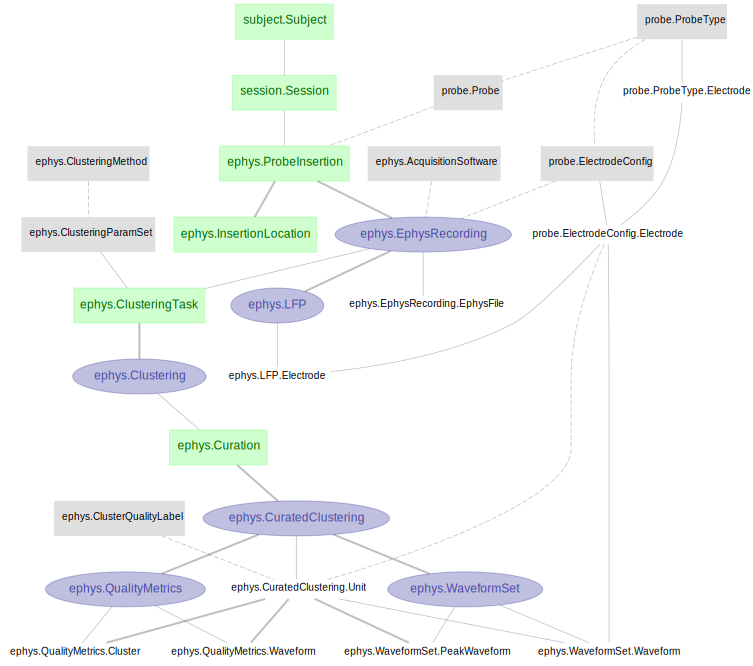

In [7]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(probe)
    + dj.Diagram(ephys)
)

As evident, this data pipeline is fairly comprehensive, encompassing several tables associated with different Array Electrophysiology components like ephys recording, probe, and clustering. A few tables, such as `Subject` or `Session`, while integral to the pipeline, fall outside the scope of `element-array-ephys` tutorial as they are upstream. 

Our focus in this tutorial will be primarily on the two core schemas:

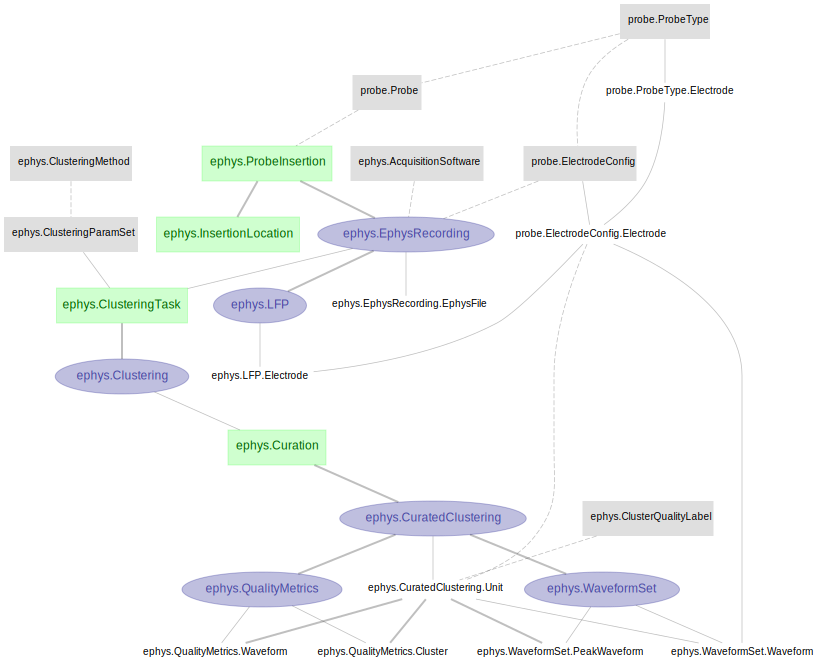

In [8]:
dj.Diagram(probe) + dj.Diagram(ephys)

This diagram represents an example of the `element-array-ephys` pipeline.

### **Step 1 - Insert Example Data into Subject and Session tables**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` functions.

In [9]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


In [10]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname=""  : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



In [11]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [12]:
subject.Subject.insert1(
    dict(subject="subject5", subject_birth_date="2023-01-01", sex="U")
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject5,,U,2023-01-01,


Let's repeat the steps above for the `Session` table and see how the output varies between
`.describe` and `.heading`.

In [13]:
print(session.Session.describe())

-> subject.Subject
session_datetime     : datetime                     



In [14]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [15]:
session_key = dict(subject="subject5", session_datetime="2023-01-01 00:00:00")

In [16]:
session.Session.insert1(session_key)
session.Session()

subject,session_datetime
subject5,2023-01-01 00:00:00


### **Step 2: Register the Electrophysiology Recording information for each Probe**


Every experimental session produces a set of data files. The purpose of the `SessionDirectory` table is to locate these files. It references a directory path relative to a root directory, defined in `dj.config[\"custom\"]`. More information about `dj.config` is provided in the [Documentation](https://datajoint.com/docs/elements/user-guide/).

In [17]:
session.SessionDirectory.insert1(
    dict(**session_key, session_dir="raw/subject5/session1")
)
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject5,2023-01-01 00:00:00,raw/subject5/session1


As the Diagram indicates, the tables in the `probe` schemas need to
contain data before the tables in the `ephys` schema accept any data. Let's
start by inserting into `probe.Probe`, a table containing metadata about a
multielectrode probe. 

In [18]:
probe.Probe.insert1(
    dict(probe="714000838", probe_type="neuropixels 1.0 - 3B")
)  # this info could be achieve from neuropixels meta file.
probe.Probe()

probe unique identifier for this model of probe (e.g. serial number),probe_type e.g. neuropixels_1.0,probe_comment
714000838,neuropixels 1.0 - 3B,


The probe metadata is used by the downstream `ProbeInsertion` table which we
insert data into in the cells below:

In [19]:
print(ephys.ProbeInsertion.describe())

# Probe insertion implanted into an animal for a given session.
-> session.Session
insertion_number     : tinyint unsigned             
---
-> probe.Probe



In [20]:
ephys.ProbeInsertion.heading

# Probe insertion implanted into an animal for a given session.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
---
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)

In [21]:
ephys.ProbeInsertion.insert1(
    dict(
        session_key,
        insertion_number=1,
        probe="714000838",
    )
)  # probe, subject, session_datetime needs to follow the restrictions of foreign keys.
ephys.ProbeInsertion()

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject5,2023-01-01 00:00:00,1,714000838


Confirm the inserted data:

In [22]:
ephys.ProbeInsertion()

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject5,2023-01-01 00:00:00,1,714000838


In the upcoming cells, populate the `ephys.EphysRecording` table and its part table `ephys.EphysRecording.EphysFile` will extract and store the recording information from a given experimental session.


In [23]:
ephys.EphysRecording()

subject,session_datetime,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz),recording_datetime datetime of the recording from this probe,recording_duration (seconds) duration of the recording from this probe


In [24]:
ephys.EphysRecording.EphysFile()

subject,session_datetime,insertion_number,file_path filepath relative to root data directory


In [25]:
ephys.EphysRecording.populate(session_key, display_progress=True)

EphysRecording: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Let's view the information was entered into each of these tables:

In [26]:
ephys.EphysRecording()

subject,session_datetime,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz),recording_datetime datetime of the recording from this probe,recording_duration (seconds) duration of the recording from this probe
subject5,2023-01-01 00:00:00,1,8d4cc6d8-a02d-42c8-bf27-7459c39ea0ee,SpikeGLX,30000.0,2018-07-03 20:32:28,338.666


In [27]:
ephys.EphysRecording.EphysFile()

subject,session_datetime,insertion_number,file_path filepath relative to root data directory
subject5,2023-01-01 00:00:00,1,raw/subject5/session1/probe_1/npx_g0_t0.imec.ap.meta


### **Step 3: Run the Clustering Task**

We're almost ready to spike sort the data with `kilosort`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
define the kilosort parameters in a dictionary and insert them into a DataJoint table
`ClusteringParamSet`. This table keeps track of all combinations of your spike sorting
parameters. You can choose which parameters are used during processing in a later step.

Let's view the attributes and insert data into `ephys.ClusteringParamSet`.

In [28]:
ephys.ClusteringParamSet.heading

# Parameter set to be used in a clustering procedure
paramset_idx         : smallint                     # 
---
clustering_method    : varchar(16)                  # 
paramset_desc        : varchar(128)                 # 
param_set_hash       : uuid                         # 
params               : longblob                     # dictionary of all applicable parameters

In [29]:
# insert clustering task manually
params_ks = {
    "fs": 30000,
    "fshigh": 150,
    "minfr_goodchannels": 0.1,
    "Th": [10, 4],
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "ThPr": 8,
    "spkTh": -6,
    "reorder": 1,
    "nskip": 25,
    "GPU": 1,
    "Nfilt": 1024,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "whiteningRange": 32,
    "nSkipCov": 25,
    "scaleproc": 200,
    "nPCs": 3,
    "useRAM": 0,
}
ephys.ClusteringParamSet.insert_new_params(
    clustering_method="kilosort2",
    paramset_idx=0,
    params=params_ks,
    paramset_desc="Spike sorting using Kilosort2",
)
ephys.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,de78cee1-526f-319e-b6d5-8a2ba04963d8,=BLOB=


Now that we've inserted kilosort parameters into the `ClusteringParamSet` table,
we're almost ready to sort our data. DataJoint uses a `ClusteringTask` table to
manage which `EphysRecording` and `ClusteringParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [30]:
ephys.ClusteringTask.heading

# Manual table for defining a clustering task ready to be run
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
paramset_idx         : smallint                     # 
---
clustering_output_dir="" : varchar(255)                 # clustering output directory relative to the clustering root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation

The `ClusteringTask` table contains two important attributes: 
+ `paramset_idx` 
+ `task_mode` 

The `paramset_idx` attribute tracks
your kilosort parameter sets. You can choose the parameter set using which 
you want spike sort ephys data. For example, `paramset_idx=0` may contain
default parameters for kilosort processing whereas `paramset_idx=1` contains your custom parameters for sorting. This
attribute tells the `Processing` table which set of parameters you are processing in a given `populate()`.

The `task_mode` attribute can be set to either `load` or `trigger`. When set to `load`,
running the processing step initiates a search for exisiting kilosort output files. When set to `trigger`, the
processing step will run kilosort on the raw data. 

In [31]:
ephys.ClusteringTask.insert1(
    dict(
        session_key,
        insertion_number=1,
        paramset_idx=0,
        task_mode="load",  # load or trigger
        clustering_output_dir="processed/subject5/session1/probe_1/kilosort2-5_1",
    )
)

In [32]:
ephys.Clustering.populate(session_key, display_progress=True)

Clustering: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


### **Step 4: Curate the Clustering Results (Optional)**

While spike sorting is completed in the above step, you can optionally curate
the output of image processing using the `Curation` table. For this demo, we
will simply use the results of the spike sorting output from the `Clustering` task.

In [33]:
ephys.Curation.heading

# Manual curation procedure
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
paramset_idx         : smallint                     # 
curation_id          : int                          # 
---
curation_time        : datetime                     # time of generation of this set of curated clustering results
curation_output_dir  : varchar(255)                 # output directory of the curated results, relative to root data directory
quality_control      : tinyint                      # has this clustering result undergone quality control?
manual_curation      : tinyint                      # has manual curation been performed on this clustering result?
curation_note=""     : varchar(2000)                # 

In [34]:
clustering_key = (ephys.ClusteringTask & session_key).fetch1("KEY")
ephys.Curation().create1_from_clustering_task(clustering_key)

Once the `Curation` table receives an entry, we can populate the remaining
tables in the workflow including `CuratedClustering`, `WaveformSet`, and `LFP`. 

In [1]:
ephys.CuratedClustering.populate(session_key, display_progress=True)
ephys.LFP.populate(session_key, display_progress=True)
ephys.WaveformSet.populate(session_key, display_progress=True)

NameError: name 'ephys' is not defined

Now that we've populated the tables in this DataJoint pipeline, there are one of
several next steps. If you have an existing pipeline for
aligning waveforms to behavior data or other stimuli, you can easily
invoke `element-event` or define your custom DataJoint tables to extend the
pipeline.

### **Step 5: Visualization of Results**

In this tutorial, we will do some exploratory analysis by fetching the data from the database and creating a few plots.

In [ ]:
lfp_average = (ephys.LFP & "insertion_number = '1'").fetch1("lfp_mean")

In the query above, we fetch a single `lfp_mean` attribute from the `LFP` table.
We also restrict the query to insertion number 1.

Let's go ahead and plot the LFP mean.

In [ ]:
plt.plot(lfp_average)
plt.title("Average LFP Waveform for Insertion 1")
plt.xlabel("Samples")
plt.ylabel("microvolts (uV)");

DataJoint queries are a highly flexible tool to manipulate and visualize your data.
After all, visualizing traces or generating rasters is likely just the start of
your analysis workflow. This can also make the queries seem more complex at
first. However, we'll walk through them slowly to simplify their content in this notebook. 

The examples below perform several operations using DataJoint queries:
- Fetch the primary key attributes of all units that are in `insertion_number=1`.
- Use **multiple restrictions** to fetch timestamps and create a raster plot.
- Use a **join** operation and **multiple restrictions** to fetch a waveform
  trace, along with unit data to create a single waveform plot

In [ ]:
insert_key = (ephys.ProbeInsertion & "insertion_number = '1'").fetch1("KEY")
units, unit_spiketimes = (
    ephys.CuratedClustering.Unit
    & insert_key
    & 'unit IN ("6","7","9","14","15","17","19")'
).fetch("unit", "spike_times")

In [ ]:
x = np.hstack(unit_spiketimes)
y = np.hstack([np.full_like(s, u) for u, s in zip(units, unit_spiketimes)])
plt.plot(x, y, "|")
plt.xlabel("Time (s)")
plt.ylabel("Unit");

In [ ]:
unit_key = (ephys.CuratedClustering.Unit & insert_key & "unit = '15'").fetch1("KEY")
unit_data = (
    ephys.CuratedClustering.Unit * ephys.WaveformSet.PeakWaveform & unit_key
).fetch1()

In [ ]:
unit_data

In [ ]:
sampling_rate = (ephys.EphysRecording & insert_key).fetch1(
    "sampling_rate"
) / 1000  # in kHz
plt.plot(
    np.r_[: unit_data["peak_electrode_waveform"].size] * 1 / sampling_rate,
    unit_data["peak_electrode_waveform"],
)
plt.xlabel("Time (ms)")
plt.ylabel(r"Voltage ($\mu$V)");

## Summary

Following this tutorial, we've efficiently: 
- covered the essential functionality of `element-array-ephys`
- acquired the skills to register the electrophysiology recordings for each probe in each experimental session
- insert data into tables
- execute the spike sort with Kilosort
- visualize the results 

#### Documentation and DataJoint tutorials

For detailed documentation on `element-array-ephys`:

[`DataJoint Element for Extracellular Electrophysiology  - Documentation`](https://datajoint.com/docs/elements/element-array-ephys/)

For detailed documentation and tutorials on general DataJoint principles that support collaboration, automation, reproducibility, and visualizations:

[`DataJoint for Python - Interactive Tutorials`](https://github.com/datajoint/datajoint-tutorials) covers fundamentals, including table tiers, query operations, fetch operations, automated computations with the make function, and more.

[`DataJoint for Python - Documentation`](https://datajoint.com/docs/core/datajoint-python/0.14/)

#### Run this tutorial on your own data

Throughout this notebook, we've used DataJoint to work with database tables and keep
data organized and automate analyses to increase efficiency of data processing. We've
inserted data into tables, used queries to retrieve, manipulate, and visualize ephys data.

Remember, this is just the beginning. As you grow familiar with DataJoint, you'll
uncover even more ways to harness its capabilities for your specific research needs. 


To run this tutorial notebook on your own data, please use the following steps:
- Download the mysql-docker image for DataJoint and run the container according to the
  instructions provide in the repository.
- Create a fork of this repository to your GitHub account.
- Clone the repository and open the files using your IDE.
- Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code. 

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

- Run this code block above and proceed with the rest of the notebook.